### Import Library yang Dibutuhkan

In [32]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns

Kode di atas berfungsi untuk mengimpor berbagai library Python esensial yang diperlukan untuk eksekusi program. Library ini menyediakan fungsionalitas komprehensif, mulai dari pemrosesan dan manipulasi citra melalui `os`, `cv2`, `matplotlib.pyplot`, dan `skimage.feature`, hingga analisis dan manajemen data dengan `numpy`, `pandas`, dan `scipy.stats`. Selanjutnya, library untuk pemodelan dan evaluasi machine learning juga disertakan, yaitu sklearn dan seaborn, yang memungkinkan tahapan seperti pembagian data, ekstraksi fitur tekstur, klasifikasi menggunakan berbagai algoritma (contohnya Random Forest, SVM, dan K-Nearest Neighbors), serta analisis performa model melalui beragam metrik dan visualisasi.

### Fungsi Resize

In [33]:
def resize(image, new_width, new_height):
    old_height = image.shape[0]
    old_width = image.shape[1]

    if len(image.shape) == 3:
        channels = image.shape[2]
        resized_image = np.zeros((new_height, new_width, channels), dtype=image.dtype)
    else:
        resized_image = np.zeros((new_height, new_width), dtype=image.dtype)

    scale_x = old_width / new_width
    scale_y = old_height / new_height

    for y in range(new_height):
        for x in range(new_width):
            src_x = int(round(x * scale_x))
            src_y = int(round(y * scale_y))

            src_x = min(src_x, old_width - 1)
            src_y = min(src_y, old_height - 1)
            
            resized_image[y, x] = image[src_y, src_x]

    return resized_image

Kode di atas mendefinisikan fungsi resize yang berguna untuk mengubah dimensi sebuah gambar. Fungsi ini dirancang untuk menyesuaikan gambar ke new_width (lebar baru) dan new_height (tinggi baru) yang ditentukan. Prosesnya melibatkan perhitungan skala perubahan ukuran untuk setiap sumbu, kemudian melakukan iterasi pada setiap piksel di gambar hasil resized_image. Untuk setiap piksel di gambar baru, nilai piksel yang sesuai diambil dari posisi yang dihitung di gambar asli. Fungsi ini mampu menangani baik gambar berwarna (dengan 3 channel) maupun gambar grayscale (dengan 1 channel).

## Ambil Data

Struktur folder dataset sebagai berikut:
```
.
└──Dog
    ├── label1
    ├   ├── image1.jpg
    ├   ├── image2.jpg
    ├   ├── image3.jpg
    ├   └── dst..
    ├── label2
    ├── label3
    └── label4
```

In [34]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("Dogs\\"):
    sub_folder_files = os.listdir(os.path.join("Dogs\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("Dogs\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = resize(img, 256, 256)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)


Kode di atas menangani proses memuat dan mempersiapkan data gambar dari folder "Dogs". Setiap gambar dibaca dari direktori, lalu ukurannya diubah menjadi 256x256 piksel menggunakan fungsi resize yang sudah ada. Setelah itu, semua gambar dikonversi menjadi format gambar grayscale. Data gambar yang telah diproses, label kategori yang diambil dari nama sub-folder, dan nama file asli kemudian disimpan dalam bentuk array NumPy untuk memudahkan analisis lebih lanjut.

#### Menampilkan Sampel Gambar dalam Grid Per Label

Kode di bawah akan secara otomatis menyesuaikan jumlah baris yang akan diplot berdasarkan jumlah label unik yang diminta (3 baris). Kemudian, untuk setiap label, skrip akan memilih 5 gambar acak dan menampilkannya di baris yang sesuai. Setiap gambar akan menampilkan label kategorinya sebagai judul, memberikan gambaran yang jelas dan terorganisir.

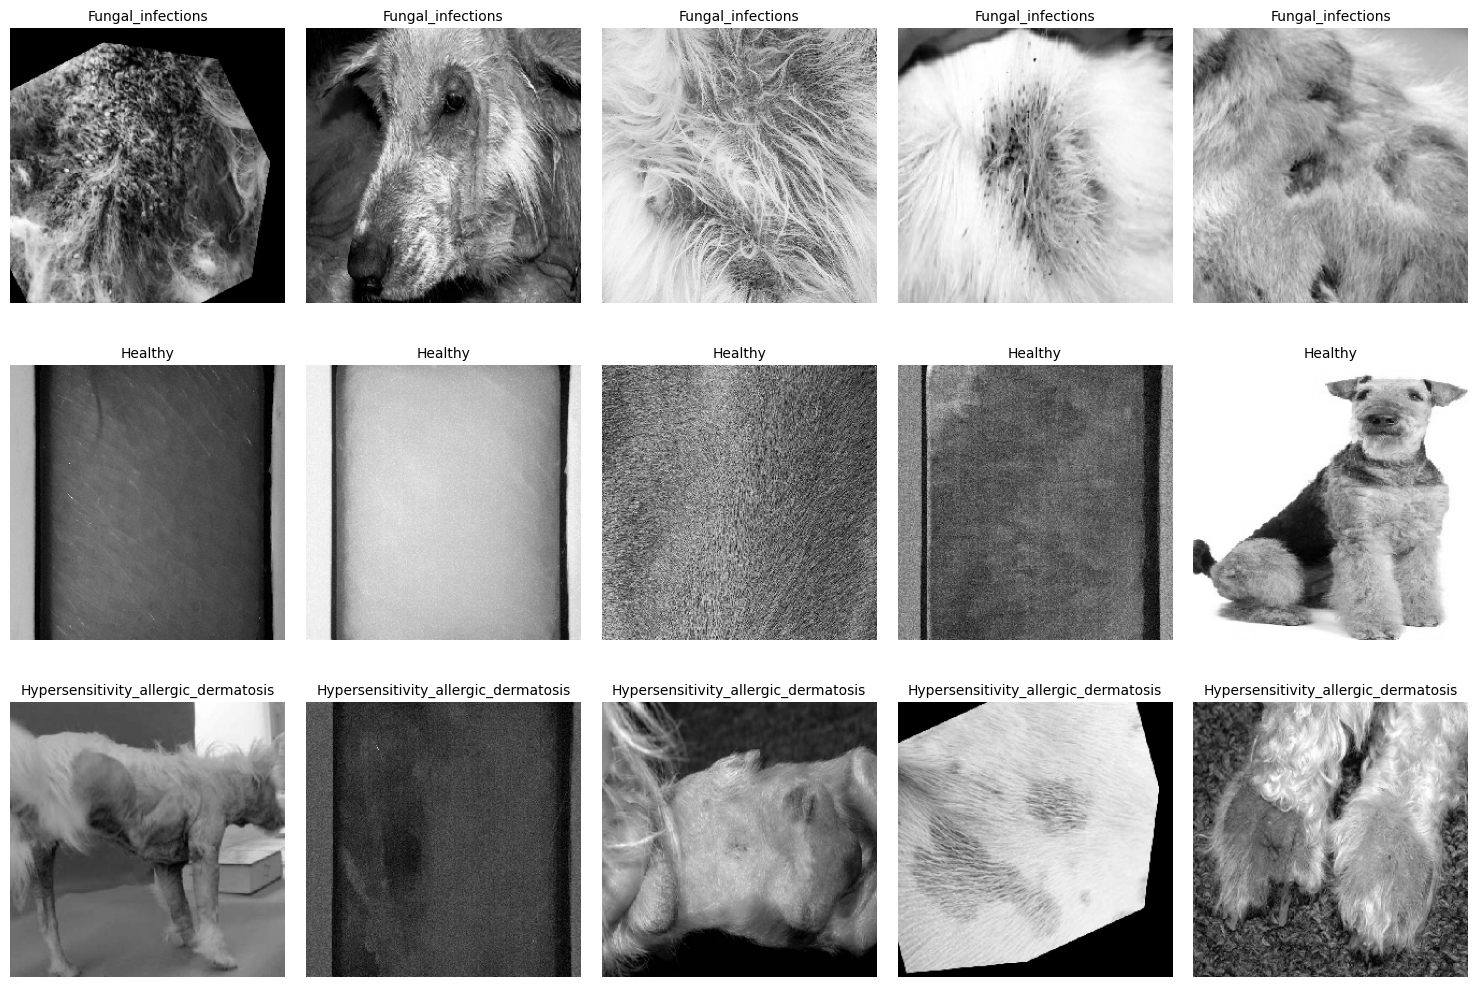

In [35]:
rows_to_display = 3
cols_to_display = 5
num_samples_per_label = cols_to_display
unique_labels = np.unique(labels)
num_unique_labels = len(unique_labels)

if num_unique_labels < rows_to_display:
    print(f"Peringatan: Hanya ditemukan {num_unique_labels} label unik. Tidak dapat membuat {rows_to_display} baris yang berbeda untuk label.")
    labels_for_display = unique_labels
    actual_rows_plotted = num_unique_labels
else:
    labels_for_display = unique_labels[:rows_to_display]
    actual_rows_plotted = rows_to_display


plt.figure(figsize=(cols_to_display * 3, actual_rows_plotted * 3.5))

current_subplot_index = 1
for label_name in labels_for_display:
    indices_for_label = np.where(labels == label_name)[0]
    
    num_available_for_label = len(indices_for_label)
    
    selected_indices = np.random.choice(
        indices_for_label,
        min(num_available_for_label, num_samples_per_label),
        replace=(num_available_for_label < num_samples_per_label)
    )
    
    for img_idx in selected_indices:
        if current_subplot_index > (actual_rows_plotted * cols_to_display):
            break

        img_display = data[img_idx]
        
        plt.subplot(actual_rows_plotted, cols_to_display, current_subplot_index)
        
        if len(img_display.shape) == 3:
            img_display_rgb = cv.cvtColor(img_display, cv.COLOR_BGR2RGB)
            plt.imshow(img_display_rgb)
        else:
            plt.imshow(img_display, cmap='gray')
            
        plt.title(f'{label_name}', fontsize=10)
        plt.axis('off')
        
        current_subplot_index += 1
    
    if current_subplot_index > (actual_rows_plotted * cols_to_display):
        break

plt.tight_layout(pad=1.5)
plt.show()

## Augmentasi Data

### Fungsi Augmentasi yang Digunakan

#### Fungsi Rotasi

In [36]:
def rotasi(image, sudut):
    height, width = image.shape[0], image.shape[1]
    pusat_rotasi = np.array([width // 2, height // 2])
    rad_rotasi = np.radians(sudut)
    cosine = np.cos(rad_rotasi)
    sine = np.sin(rad_rotasi)

    citra_rotasi = np.zeros_like(image)

    for x in range(height):
        for y in range(width):
            xp = int((x-pusat_rotasi[1]) * cosine - (y - pusat_rotasi[0]) * sine + pusat_rotasi[1])
            yp = int((x - pusat_rotasi[0]) * sine + (y - pusat_rotasi[0]) * cosine + pusat_rotasi[0])
            if 0 <= xp < height and 0 <= yp < width:
                citra_rotasi[x,y] = image[xp, yp]   
    return citra_rotasi

Kode di atas mendefinisikan sebuah fungsi rotasi kustom yang berfungsi untuk memutar gambar berdasarkan sudut yang ditentukan. Fungsi ini beroperasi dengan terlebih dahulu menghitung pusat rotasi gambar dan mengonversi sudut putaran ke dalam satuan radian. Selanjutnya, dilakukan iterasi pada setiap piksel di gambar hasil citra_rotasi. Untuk setiap piksel, posisi piksel yang sesuai di gambar asli akan dihitung setelah melalui transformasi rotasi. Jika posisi hasil rotasi masih berada dalam batas dimensi gambar, nilai piksel dari gambar asli akan disalin ke gambar yang sudah dirotasi, sehingga menghasilkan citra yang telah diputar.

#### Proses Augmentasi Data Gambar

In [37]:

data_augmented = list(data) 
labels_augmented = list(labels) 
file_name_augmented = list(file_name) 

for i in range(len(data)):
    img = data[i]
    label = labels[i]
    original_filename = file_name[i]

    rows, cols = img.shape
    center_x, center_y = cols / 2, rows / 2


    angles = [-30, -25, -20, -15, -10, -5, 5, 10, 15, 20, 25, 30] 
    for angle_deg in angles:
        rotated_img = rotasi(img, angle_deg)
        
        data_augmented.append(rotated_img)
        labels_augmented.append(label)
        file_name_augmented.append(f"{original_filename}_rot{angle_deg}.jpg")

    flipped_h = img[::-1, :]
    data_augmented.append(flipped_h)
    labels_augmented.append(label)
    file_name_augmented.append(f"{original_filename}_flipH.jpg")

    flipped_v = img[:, ::-1]
    data_augmented.append(flipped_v)
    labels_augmented.append(label)
    file_name_augmented.append(f"{original_filename}_flipV.jpg")

data_augmented = np.array(data_augmented)
labels_augmented = np.array(labels_augmented)
file_name_augmented = np.array(file_name_augmented)

Kode di atas menjalankan proses augmentasi data untuk memperluas dan menambah variasi pada dataset gambar yang sudah ada. Teknik augmentasi yang diterapkan meliputi beberapa transformasi pada setiap gambar asli:

Pertama, setiap gambar dirotasi dengan serangkaian sudut yang telah ditentukan, mulai dari -30 hingga 30 derajat, untuk menciptakan keberagaman orientasi. Selain rotasi, setiap gambar juga digandakan dengan melakukan flip horizontal (membalik gambar secara mendatar) dan flip vertikal (membalik gambar secara tegak).

Setelah semua operasi augmentasi selesai, hasil akhirnya adalah dataset gambar yang jauh lebih besar, disimpan dalam data_augmented, beserta label (labels_augmented) dan nama file baru (file_name_augmented) yang sesuai. Semua data ini kemudian dikonversi menjadi array NumPy untuk pemrosesan lebih lanjut.

#### Menampilkan Ukuran Data Sebelum dan Sesudah Augmentasi

In [38]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  254
Data setelah augmentasi:  3810


Kode di atas menampilkan jumlah data gambar sebelum dan sesudah proses augmentasi. Output dari kode ini akan menunjukkan seberapa efektif teknik augmentasi dalam memperbanyak jumlah sampel data yang tersedia untuk pelatihan model.

## Persiapan Data

### Fungsi Pra-pemrosesan Data

In [39]:
def prepro1(img):
    img = img.astype(np.uint8)
    equalized_img = np.zeros_like(img)

    frekuensi = np.zeros(256)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            warna = img[i,j]
            frekuensi[warna]+=1

    pi = np.zeros_like(frekuensi)
    for i in range(len(frekuensi)):
        pi[i] = frekuensi[i]/(img.shape[0]*img.shape[1])

    cdf = np.zeros_like(pi)
    for i in range(len(pi)):
        if(i == 0):
            cdf[i] = pi[i]
        else:
            cdf[i] = cdf[i-1] + pi[i]
    
    sk = np.zeros_like(cdf)
    sk = np.round(255 * cdf).astype(np.uint8)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            equalized_img[i,j] = sk[img[i,j]]
    
    return equalized_img

def prepro2(image):
    sharp = ([[1/9, 1/9, 1/9], 
            [1/9, 8/9, 1/9], 
            [1/9, 1/9, 1/9]])
    kernel = np.array(sharp)

    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    padded_img = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
    result = np.zeros_like(image, dtype=np.float32)

    for i in range(img_height):
        for j in range(img_width):
            region = padded_img[i:i+kernel_height, j:j+kernel_width]
            result[i, j] = np.sum(region * kernel)

    min_val = np.min(result)
    max_val = np.max(result)

    img_norm = (result - min_val) / (max_val - min_val)
    return (img_norm * 255).astype(np.uint8)

def cari_median(array):
    i = len(array)
    baris_array = sorted(array)
    if i % 2 == 0:
        kiri = baris_array[i//2]
        kanan = baris_array[i//2 - 1]
        cari_median = (kiri + kanan)/2
    else:
        cari_median = baris_array[i//2]
        
    return cari_median

def prepro3(image):
    size = 3
    pad = np.pad(image, ((size//2, size//2), (size//2, size//2)), mode='constant', constant_values=0)
    
    result = np.zeros(image.shape).astype(int)
    panjang, lebar = image.shape

    for i in range(panjang):
        for j in range(lebar):
            temp = np.zeros(size * size)
            indeks = 0
            for k in range(size):
                for l in range(size):
                    temp[indeks] += pad[i+k,j+l]
                    indeks+=1
            result[i,j] = cari_median(temp)         
    return result

Kode di atas mendefinisikan beberapa fungsi kustom untuk pra-pemrosesan gambar, yang bertujuan meningkatkan kualitas citra sebelum analisis.

* `prepro1(img)` melakukan ekualisasi histogram pada gambar grayscale untuk meratakan distribusi intensitas piksel, sehingga meningkatkan kontras dan memperjelas detail. Proses ini melibatkan penghitungan frekuensi intensitas piksel dan penggunaan fungsi distribusi kumulatif (CDF) untuk penyesuaian nilai piksel.
* `prepro2(image)` menerapkan filter konvolusi kustom dengan kernel sharpening ringan. Fungsi ini melakukan padding gambar, menerapkan operasi konvolusi, lalu menormalisasi kembali rentang nilai piksel agar sesuai untuk tampilan gambar.
* `cari_median(array)` adalah fungsi pembantu untuk menghitung nilai median dari sebuah array. Fungsi ini mengurutkan array dan menentukan nilai tengahnya, mengakomodasi jumlah elemen ganjil maupun genap.
* `prepro3(image)` mengimplementasikan filter median 3×3, yang efektif untuk mengurangi noise, terutama noise salt-and-pepper. Ini bekerja dengan mengganti nilai setiap piksel dengan median dari piksel-piksel di sekitarnya dalam jendela yang ditentukan, memanfaatkan fungsi cari_median.

### Pra-pemrosesan

#### Pra-pemrosesan Data dengan Kombinasi Fungsi

In [ ]:
all_processed_stages = []
dataPreprocessed = []

for i in range(len(data_augmented)):
    img = data_augmented[i]
    current_stages = {"Original": img.copy()}

    img_proc_step = prepro1(img)
    current_stages["prepro1"] = img_proc_step.copy()

    img_proc_step = prepro2(img_proc_step)
    current_stages["prepro2"] = img_proc_step.copy()

    img_final_proc = prepro3(img_proc_step)
    current_stages["prepro3"] = img_final_proc.copy()

    all_processed_stages.append(current_stages)
    dataPreprocessed.append(img_final_proc.astype(np.uint8))

Kode di atas menjalankan serangkaian tahapan pra-pemrosesan pada setiap gambar di dataset data_augmented. Setiap gambar melalui tiga fungsi pra-pemrosesan secara berurutan:

* `prepro1(img)`: Ekualisasi histogram untuk ningkatin kontras.
* `prepro2(img_proc)`: Operasi sharpening ringan untuk ningkatin detail.
* `prepro3(img_proc)`: Filter median untuk ngurangin noise.

Hasil dari setiap fungsi menjadi input untuk fungsi berikutnya, memastikan gambar ditingkatkan secara bertahap. Gambar yang sudah diproses kemudian ditambahkan ke list dataPreprocessed sebagai data berjenis uint8, siap untuk analisis lebih lanjut.

#### Menampilkan Sampel Gambar per Label dengan Evolusi Pra-pemrosesan

Kode di bawah ini akan secara otomatis memilih 5 gambar dari setiap label unik di dataset. Untuk setiap gambar yang dipilih, sebuah jendela plot baru akan muncul. Jendela ini akan menampilkan gambar aslinya di satu sisi, dan di sisi lain, evolusi gambar setelah melewati setiap fungsi pra-pemrosesan secara berurutan hingga prepro3. Ini memungkinkan Anda melihat secara langsung bagaimana gambar berubah di setiap tahapan hingga pra-pemrosesan ketiga.

In [ ]:
num_samples_per_label = 5 # Jumlah gambar yang akan ditampilkan per label
unique_labels = np.unique(labels)

stage_titles = ["Original", "prepro1", "prepro2", "prepro3"]
num_stages = len(stage_titles)

print(f"Memulai visualisasi... Akan menampilkan {num_samples_per_label} gambar per label dari total {len(unique_labels)} label unik.")
print(f"Setiap gambar sampel akan divisualisasikan melalui {num_stages} tahap (original + prepro1, 2, 3).")
print(f"Akan ada total {len(unique_labels) * num_samples_per_label} figure yang dihasilkan.")

for label_name in unique_labels:
    indices_for_label = np.where(labels == label_name)[0]
    
    num_available_for_label = len(indices_for_label)
    selected_indices = np.random.choice(
        indices_for_label, 
        min(num_available_for_label, num_samples_per_label), 
        replace=(num_available_for_label < num_samples_per_label)
    )
    
    print(f"\nMenampilkan sampel untuk Label: '{label_name}'")
    for idx_sample in selected_indices:
        current_image_stages = all_processed_stages[idx_sample]
        
        plt.figure(figsize=(num_stages * 4, 5))
        plt.suptitle(f'Evolusi Pra-pemrosesan - Label: {label_name} (Gambar ID Asli: {idx_sample})', fontsize=14, y=1.02)

        for j, stage_title in enumerate(stage_titles):
            img_to_plot = current_image_stages[stage_title]
            
            plt.subplot(1, num_stages, j + 1)
            if len(img_to_plot.shape) == 3:
                plt.imshow(cv.cvtColor(img_to_plot, cv.COLOR_BGR2RGB))
            else:
                plt.imshow(img_to_plot, cmap='gray')
            
            plt.title(stage_title, fontsize=10)
            plt.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

### Ekstraksi Fitur

#### Fungsi Ekstraksi Fitur GLCM

In [ ]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Kode di atas mendefinisikan fungsi glcm yang bertugas mengekstrak Gray Level Co-occurrence Matrix (GLCM) dari sebuah gambar. Fungsi ini membutuhkan gambar dan sudut orientasi (derajat) sebagai input. Sudut yang diterima adalah 0 (sudut 0°), 45 (sudut 45°), 90 (sudut 90°), dan 135 (sudut 135°). GLCM dihitung dengan jarak piksel sebesar 1, menggunakan 256 tingkat keabuan (gray levels), dan menghasilkan matriks yang simetris serta dinormalisasi.

#### Fungsi Ekstraksi Fitur Korelasi

In [ ]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Kode di atas mendefinisikan fungsi correlation yang digunakan untuk mengekstrak fitur Korelasi dari sebuah matriks GLCM. Fungsi ini memanfaatkan graycoprops dari library skimage.feature untuk menghitung nilai korelasi dari GLCM yang diberikan sebagai input. Korelasi mengukur linearitas hubungan ketergantungan gray-level antar piksel, menunjukkan seberapa terkait piksel-piksel yang berdekatan.

#### Fungsi Ekstraksi Fitur Disimilaritas

In [ ]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Kode di atas mendefinisikan fungsi dissimilarity yang dipakai untuk mengekstrak fitur Disimilaritas dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini menggunakan graycoprops dari library skimage.feature untuk menghitung nilai disimilaritas dari matriks GLCM yang diberikan sebagai input. Disimilaritas sendiri adalah ukuran kontras lokal pada gambar; nilai yang lebih tinggi nunjukkin perbedaan intensitas piksel yang lebih besar di dalam tekstur.

#### Fungsi Ekstraksi Fitur Homogenitas

In [ ]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Kode di atas mendefinisikan fungsi homogenity yang dipakai untuk mengekstrak fitur Homogenitas dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini menggunakan graycoprops dari library skimage.feature untuk menghitung nilai homogenitas dari matriks GLCM yang diberikan sebagai input. Homogenitas mengukur kedekatan distribusi elemen dalam GLCM terhadap diagonal GLCM, yang menunjukkan keseragaman tekstur pada gambar.

#### Fungsi Ekstraksi Fitur Kontras

In [ ]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Kode di atas mendefinisikan fungsi contrast yang digunakan untuk mengekstrak fitur Kontras dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini memanfaatkan graycoprops dari library skimage.feature untuk menghitung nilai kontras dari matriks GLCM yang diberikan sebagai input. Kontras merupakan ukuran intensitas perbedaan lokal dalam gambar; nilai yang lebih tinggi mengindikasikan kontras tekstur yang lebih jelas.

#### Fungsi Ekstraksi Fitur Angular Second Moment (ASM)

In [ ]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Kode di atas mendefinisikan fungsi ASM yang dipakai buat ngekstrak fitur Angular Second Moment (ASM) dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini menggunakan graycoprops dari library skimage.feature untuk menghitung nilai ASM dari matriks GLCM yang diberikan sebagai input. ASM mengukur keseragaman atau keteraturan tekstur gambar; nilai yang lebih tinggi nunjukkin tekstur yang lebih seragam.

#### Fungsi Ekstraksi Fitur Energi

In [ ]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Kode di atas mendefinisikan fungsi energy yang digunakan untuk mengekstrak fitur Energi dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini memanfaatkan graycoprops dari library skimage.feature untuk menghitung nilai energi dari matriks GLCM yang diberikan sebagai input. Energi merupakan ukuran konsentrasi pasangan piksel berulang dan homogenitas gambar; nilai yang lebih tinggi menunjukkan tekstur yang lebih seragam.

#### Fungsi Ekstraksi Fitur Entropi

In [ ]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Kode di atas mendefinisikan fungsi entropyGlcm yang digunakan untuk mengekstrak fitur Entropi dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini memanfaatkan fungsi entropy dari library scipy.stats untuk menghitung nilai entropi. Sebelum perhitungan, matriks GLCM diubah menjadi array satu dimensi (.ravel()), kemudian nilai entropinya dihitung. Entropi mengukur ketidakteraturan atau kompleksitas tekstur; nilai yang lebih tinggi menunjukkan tekstur yang lebih kompleks dan kurang seragam.

#### Perhitungan GLCM

In [ ]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode di atas melakukan perhitungan Gray Level Co-occurrence Matrix (GLCM) untuk setiap gambar yang sudah diproses dalam dataset dataPreprocessed. Untuk setiap gambar, empat matriks GLCM dihitung berdasarkan empat sudut orientasi berbeda: 0°, 45°, 90°, dan 135°. Hasil perhitungan GLCM untuk masing-masing sudut kemudian disimpan ke dalam list terpisah: Derajat0, Derajat45, Derajat90, dan Derajat135.

#### Inisialisasi List untuk Fitur GLCM

In [ ]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


Kode ini menginisialisasi sejumlah list kosong yang akan digunakan untuk menyimpan nilai-nilai fitur GLCM (Gray Level Co-occurrence Matrix) yang diekstrak dari gambar. Setiap fitur (Kontras, Disimilaritas, Homogenitas, Entropi, ASM, Energi, dan Korelasi) memiliki empat list terpisah, masing-masing sesuai dengan sudut orientasi GLCM: 0°, 45°, 90°, dan 135°. Inisialisasi ini penting dilakukan untuk memastikan semua variabel siap menampung data fitur yang akan dihitung di langkah berikutnya.

#### Ekstraksi Fitur Korelasi dari GLCM

In [ ]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)
    

Kode di atas menjalankan proses ekstraksi fitur korelasi dari setiap matriks GLCM yang sudah dihitung sebelumnya (untuk derajat 0°, 45°, 90°, dan 135°). Nilai korelasi yang diekstrak dari Derajat0, Derajat45, Derajat90, dan Derajat135 kemudian disimpan ke list masing-masing, yaitu correlation0, correlation45, correlation90, dan correlation135.

#### Ekstraksi Fitur Kontras dari GLCM

In [ ]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Kode di atas melakukan ekstraksi fitur kontras untuk setiap matriks GLCM yang sudah dihitung sebelumnya, yakni pada derajat 0°, 45°, 90°, dan 135°. Nilai kontras yang diperoleh dari Derajat0, Derajat45, Derajat90, dan Derajat135 selanjutnya ditambahkan ke dalam list masing-masing, yaitu Kontras0, Kontras45, Kontras90, dan Kontras135.

#### Ekstraksi Fitur Disimilaritas dari GLCM

In [ ]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Kode di atas melakukan ekstraksi fitur disimilaritas untuk setiap matriks GLCM yang sudah dihitung sebelumnya, yakni pada derajat 0°, 45°, 90°, dan 135°. Nilai disimilaritas yang diperoleh dari Derajat0, Derajat45, Derajat90, dan Derajat135 selanjutnya ditambahkan ke dalam list masing-masing, yaitu dissimilarity0, dissimilarity45, dissimilarity90, dan dissimilarity135.

#### Ekstraksi Fitur Homogenitas dari GLCM

In [ ]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Kode di atas melakukan ekstraksi fitur homogenitas untuk setiap matriks GLCM yang sudah dihitung sebelumnya, yaitu pada derajat 0°, 45°, 90°, dan 135°. Nilai homogenitas yang diperoleh dari Derajat0, Derajat45, Derajat90, dan Derajat135 kemudian ditambahkan ke dalam list masing-masing, yakni homogenity0, homogenity45, homogenity90, dan homogenity135.

#### Ekstraksi Fitur Entropi dari GLCM

In [ ]:
for i in range(len(dataPreprocessed)):
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)


Kode di atas melakukan ekstraksi fitur entropi untuk setiap matriks GLCM yang sudah dihitung sebelumnya, yakni pada derajat 0°, 45°, 90°, dan 135°. Nilai entropi yang diperoleh dari Derajat0, Derajat45, Derajat90, dan Derajat135 selanjutnya ditambahkan ke dalam list masing-masing, yaitu entropy0, entropy45, entropy90, dan entropy135.

#### Ekstraksi Fitur Angular Second Moment (ASM) dari GLCM

In [ ]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Kode di atas melakukan ekstraksi fitur Angular Second Moment (ASM) untuk setiap matriks GLCM yang sudah dihitung sebelumnya, yakni pada derajat 0°, 45°, 90°, dan 135°. Nilai ASM yang diperoleh dari Derajat0, Derajat45, Derajat90, dan Derajat135 kemudian ditambahkan ke dalam list masing-masing, yaitu ASM0, ASM45, ASM90, dan ASM135.

#### Ekstraksi Fitur Energi dari GLCM

In [ ]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Kode ini mengekstrak fitur energi untuk setiap matriks GLCM yang telah dihitung sebelumnya, yakni pada derajat 0°, 45°, 90°, dan 135°. Nilai energi yang diperoleh dari Derajat0, Derajat45, Derajat90, dan Derajat135 kemudian ditambahkan ke dalam list masing-masing, yaitu energy0, energy45, energy90, dan energy135.

### Menyimpan Hasil Ekstraksi ke CSV

Kode di bawah bertanggung jawab untuk mengompilasi seluruh fitur GLCM yang telah diekstraksi dari gambar, serta informasi filename dan labelnya, ke dalam sebuah objek pandas DataFrame bernama df. Setiap fitur (Kontras, Homogenitas, Disimilaritas, Entropi, ASM, Energi, dan Korelasi) untuk setiap sudut orientasi (0°, 45°, 90°, dan 135°) diorganisir sebagai kolom terpisah dalam DataFrame. Setelah itu, DataFrame ini diekspor dan disimpan sebagai file CSV dengan nama hasil_ekstraksi_1.csv, tanpa menyertakan indeks baris. Terakhir, file CSV tersebut dibaca kembali ke dalam DataFrame baru bernama hasilEkstrak untuk ditampilkan, memastikan data fitur telah tersimpan dan dapat diakses dengan benar.

In [ ]:
dataTable = {'Filename': file_name_augmented, 'Label': labels_augmented, 
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,fung1_jpg.rf.0e0deb5ac87a43b13f544b6ca5f45f7e.jpg,Fungal_infections,139.357108,233.590250,116.349203,216.399631,0.264536,0.196786,0.279552,0.196724,...,0.000259,0.000155,0.015346,0.012594,0.016082,0.012465,0.986098,0.976690,0.988377,0.978405
1,fung1_jpg.rf.32912b425b9107cd2a7b90ac1c29590a.jpg,Fungal_infections,122.258670,252.025928,151.818382,242.773856,0.335706,0.270926,0.341542,0.280123,...,0.008339,0.007734,0.090979,0.087635,0.091319,0.087944,0.989185,0.977643,0.986571,0.978464
2,fung1_jpg.rf.dd65ca74677b2d37918ea70387ee8841.jpg,Fungal_infections,124.733104,257.994510,121.430300,188.704637,0.351081,0.281033,0.361663,0.299825,...,0.011983,0.011222,0.109285,0.105498,0.109468,0.105932,0.987002,0.973040,0.987344,0.980281
3,fung2_jpg.rf.2ac413733eea46de3cc94099a6f84950.jpg,Fungal_infections,154.790380,316.219116,162.229044,245.642322,0.381880,0.321695,0.379652,0.332967,...,0.030031,0.029008,0.173725,0.170728,0.173293,0.170318,0.982697,0.964558,0.981852,0.972468
4,fung2_jpg.rf.bfdd88f4e794d851c5ddeb630b1765b8.jpg,Fungal_infections,284.632981,360.664068,185.625245,481.762261,0.236740,0.185712,0.247597,0.158772,...,0.000211,0.000112,0.013877,0.011685,0.014540,0.010588,0.969841,0.961755,0.980304,0.948913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,pic9.jpg_rot20.jpg,Hypersensitivity_allergic_dermatosis,221.991651,363.368566,87.445190,173.688997,0.385346,0.301343,0.439284,0.342121,...,0.010468,0.009823,0.101804,0.098783,0.102315,0.099109,0.980358,0.967741,0.992268,0.984580
3806,pic9.jpg_rot25.jpg,Hypersensitivity_allergic_dermatosis,208.419776,370.040769,95.992770,147.047243,0.397385,0.310975,0.441260,0.357671,...,0.014233,0.013563,0.118898,0.116172,0.119304,0.116461,0.981588,0.967203,0.991526,0.986967
3807,pic9.jpg_rot30.jpg,Hypersensitivity_allergic_dermatosis,197.073575,381.058547,111.202160,129.524983,0.406370,0.320401,0.436965,0.373730,...,0.017467,0.016832,0.131877,0.129396,0.132161,0.129737,0.982715,0.966475,0.990252,0.988604
3808,pic9.jpg_flipH.jpg,Hypersensitivity_allergic_dermatosis,213.032292,237.056947,39.654013,230.737347,0.327871,0.263917,0.439688,0.262483,...,0.000716,0.000326,0.020926,0.018122,0.026761,0.018044,0.978928,0.976512,0.996066,0.977138


## Pemilihan Fitur Berbasis Korelasi

Kode di bawah melakukan pemilihan fitur dengan strategi mengurangi redundansi berdasarkan tingkat korelasi antar fitur, serta memvisualisasikannya. 

Pertama, matriks korelasi dihitung untuk semua fitur yang diekstrak, kecuali kolom 'Label' dan 'Filename'. Kemudian, sebuah ambang batas (threshold) sebesar 0.95 ditetapkan untuk mengidentifikasi pasangan fitur yang memiliki korelasi sangat tinggi. Melalui proses iterasi, salah satu fitur dari setiap pasangan yang berkorelasi di atas ambang batas tersebut akan dihapus dari seleksi, sehingga hanya fitur-fitur dengan korelasi relatif rendah satu sama lain yang dipertahankan. Hasil dari proses ini adalah x_new, sebuah DataFrame yang hanya berisi fitur-fitur terpilih. Terakhir, sebuah heatmap dibuat menggunakan seaborn untuk secara visual merepresentasikan matriks korelasi dari fitur-fitur yang sudah diseleksi, dengan nilai korelasi ditampilkan secara numerik, membantu memastikan fitur yang tersisa memiliki korelasi antar fitur yang lebih optimal.

<Axes: >

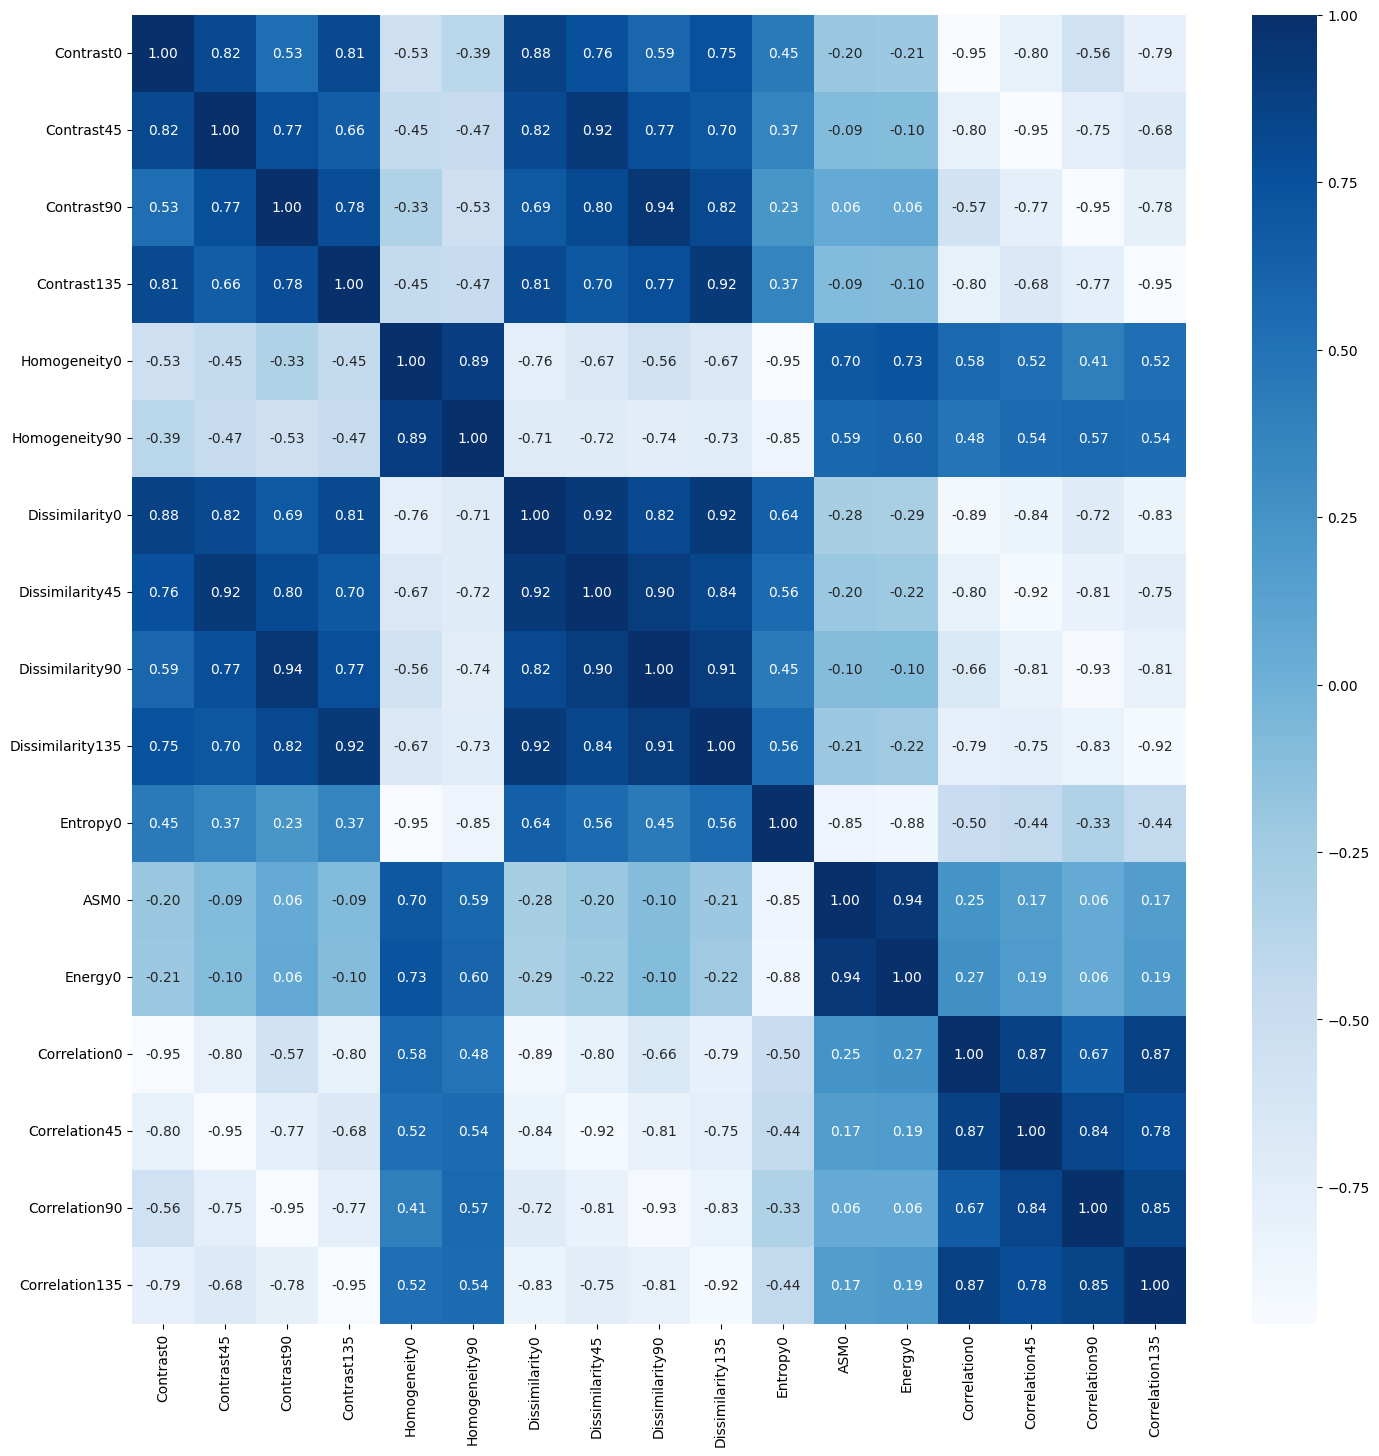

In [ ]:
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

threshold = 0.95
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")


## Pembagian Data untuk Pelatihan dan Pengujian

Kode di bawah melakukan pembagian dataset fitur (x_new) dan label (y) menjadi set pelatihan (training set) dan set pengujian (testing set). Sebanyak 20% dari total data (test_size=0.2) dialokasikan untuk set pengujian, sementara sisanya 80% digunakan sebagai set pelatihan. Parameter random_state=42 digunakan untuk memastikan bahwa pembagian data ini bersifat reproducible, artinya setiap kali kode dijalankan, hasilnya akan selalu sama. Setelah pembagian, dimensi (shape) dari X_train (fitur pelatihan) dan X_test (fitur pengujian) ditampilkan untuk memverifikasi ukuran masing-masing set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(3048, 17)
(762, 17)


## Normalisasi Data Fitur

In [ ]:
def normalize_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normalized_data = (data - mean) / std
    return normalized_data
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)

Kode di atas mendefinisikan fungsi normalize_data yang bertujuan untuk melakukan normalisasi (standardisasi) pada data fitur. 

Proses normalisasi ini mengubah skala fitur sehingga memiliki rata-rata nol dan standar deviasi satu, yang sangat penting untuk algoritma machine learning yang sensitif terhadap skala fitur. Fungsi ini menghitung nilai rata-rata (mean) dan standar deviasi (standard deviation) secara terpisah untuk setiap kolom (fitur) dari data yang diberikan, kemudian menggunakan nilai-nilai tersebut untuk mengubah setiap data point. 

Setelah fungsi didefinisikan, fungsi tersebut diterapkan pada X_train dan X_test secara terpisah, memastikan bahwa baik set pelatihan maupun set pengujian dinormalisasi berdasarkan statistik dari set masing-masing.

## Pemodelan

### Pelaporan Klasifikasi dan Inisialisasi Model

In [ ]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Kode di atas terdiri dari dua bagian utama: definisi fungsi untuk pelaporan metrik klasifikasi dan inisialisasi model machine learning. 

Pertama, fungsi generateClassificationReport didefinisikan untuk mencetak laporan klasifikasi (presisi, recall, F1-score), matriks kebingungan (confusion matrix), dan akurasi berdasarkan label sebenarnya (y_true) dan hasil prediksi (y_pred). Selanjutnya, tiga model klasifikasi diinisialisasi: Random Forest Classifier (rf) dengan 5 estimator, Support Vector Classifier (SVC) (svm) dengan kernel RBF, dan K-Nearest Neighbors (KNN) (knn) dengan 5 tetangga terdekat. Pengaturan random_state=42 pada rf dan svm memastikan hasil yang reproducible.

### Pelatihan dan Evaluasi Model Random Forest Classifier

Kode di bawah menjalankan proses pelatihan dan evaluasi untuk model Random Forest Classifier (rf). 

Pertama, model dilatih menggunakan set data pelatihan (X_train dan y_train). Setelah pelatihan, model dievaluasi pada set pelatihan itu sendiri untuk melihat performanya. Hasil evaluasi ini, termasuk laporan klasifikasi dan matriks kebingungan, dicetak di bagian "Training Set". Kemudian, model kembali dievaluasi, kali ini pada set data pengujian (X_test dan y_test) yang belum pernah dilihat model sebelumnya. Hasil evaluasi pada set pengujian ini dicetak di bagian "Testing Set", yang memberikan gambaran lebih realistis tentang kemampuan generalisasi model terhadap data baru.

In [ ]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                                      precision    recall  f1-score   support

                   Fungal_infections       0.97      0.97      0.97       863
                             Healthy       0.98      0.98      0.98      1108
Hypersensitivity_allergic_dermatosis       0.97      0.97      0.97      1077

                            accuracy                           0.98      3048
                           macro avg       0.97      0.97      0.97      3048
                        weighted avg       0.98      0.98      0.98      3048

[[ 839    9   15]
 [  12 1083   13]
 [  18    9 1050]]
Accuracy: 0.9750656167979003

------Testing Set------
                                      precision    recall  f1-score   support

                   Fungal_infections       0.75      0.81      0.78       232
                             Healthy       0.84      0.81      0.82       272
Hypersensitivity_allergic_dermatosis       0.77      0.75      0.76       258

   

### Pelatihan dan Evaluasi Model SVM Classifier

Kode di bawah mengimplementasikan proses pelatihan dan evaluasi untuk model Support Vector Machine (SVM) Classifier (svm). Model ini pertama-tama dilatih menggunakan set data pelatihan (X_train dan y_train). Setelah proses pelatihan selesai, performa model dievaluasi pada set pelatihan itu sendiri. Hasil evaluasi tersebut, yang mencakup laporan klasifikasi dan matriks kebingungan, akan ditampilkan pada bagian "Training Set". Selanjutnya, model kembali dievaluasi, namun kali ini pada set data pengujian (X_test dan y_test), yang belum pernah digunakan oleh model sebelumnya. Hasil evaluasi pada set pengujian ini ditampilkan pada bagian "Testing Set", memberikan indikasi yang lebih akurat mengenai kemampuan generalisasi model terhadap data baru.

In [ ]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                                      precision    recall  f1-score   support

                   Fungal_infections       0.62      0.46      0.53       863
                             Healthy       0.73      0.77      0.75      1108
Hypersensitivity_allergic_dermatosis       0.58      0.67      0.62      1077

                            accuracy                           0.65      3048
                           macro avg       0.65      0.63      0.63      3048
                        weighted avg       0.65      0.65      0.64      3048

[[396 115 352]
 [ 81 854 173]
 [157 198 722]]
Accuracy: 0.6469816272965879

------Testing Set------
                                      precision    recall  f1-score   support

                   Fungal_infections       0.66      0.48      0.56       232
                             Healthy       0.76      0.80      0.78       272
Hypersensitivity_allergic_dermatosis       0.59      0.71      0.64       258

           

### Pelatihan dan Evaluasi Model KNN Classifier

Kode di bawah menjalankan proses pelatihan dan evaluasi untuk model K-Nearest Neighbors (KNN) Classifier (knn) yang sebelumnya sudah diinisialisasi.

Pertama, model knn dilatih menggunakan set data pelatihan (X_train dan y_train). Setelah pelatihan, model dievaluasi dua kali:

* Evaluasi dengan Training Set:
Model digunakan untuk memprediksi label dari data pelatihan itu sendiri. Hasil prediksinya (y_pred) dibandingkan dengan label aslinya (y_train) menggunakan fungsi generateClassificationReport untuk menampilkan metrik evaluasi lengkap. Ini membantu memeriksa seberapa baik model belajar dari data yang sudah dilihatnya.
* Evaluasi dengan Testing Set:
Model digunakan untuk memprediksi label dari data pengujian (X_test), yang belum pernah dilihat model selama pelatihan. Hasil prediksinya (y_pred) dibandingkan dengan label aslinya (y_test) menggunakan generateClassificationReport. Evaluasi ini sangat penting untuk melihat seberapa bagus performa model pada data baru (belum dikenal), yang menunjukkan kemampuan generalisasinya.

In [ ]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                                      precision    recall  f1-score   support

                   Fungal_infections       0.87      0.90      0.89       863
                             Healthy       0.92      0.93      0.92      1108
Hypersensitivity_allergic_dermatosis       0.90      0.87      0.88      1077

                            accuracy                           0.90      3048
                           macro avg       0.90      0.90      0.90      3048
                        weighted avg       0.90      0.90      0.90      3048

[[ 775   29   59]
 [  34 1029   45]
 [  79   62  936]]
Accuracy: 0.8989501312335958

------Testing Set------
                                      precision    recall  f1-score   support

                   Fungal_infections       0.77      0.78      0.77       232
                             Healthy       0.85      0.83      0.84       272
Hypersensitivity_allergic_dermatosis       0.76      0.78      0.77       258

  

## Visualisasi Matriks Kebingungan


Kode di bawah mendefinisikan dan menggunakan fungsi plot_confusion_matrix untuk memvisualisasikan performa klasifikasi dari setiap model yang telah dilatih (Random Forest, SVM, dan KNN) dalam bentuk matriks kebingungan.

Fungsi plot_confusion_matrix mengambil nilai sebenarnya (y_true), nilai prediksi (y_pred), dan judul plot. Di dalamnya, confusion_matrix dari sklearn.metrics digunakan untuk menghitung matriks kebingungan, yang kemudian divisualisasikan menggunakan ConfusionMatrixDisplay dan matplotlib.pyplot. Plot ini disajikan dengan colormap biru untuk kejelasan dan dilengkapi dengan judul yang relevan.

Setelah definisi fungsi, plot_confusion_matrix dipanggil tiga kali:
* Pertama, untuk menampilkan matriks kebingungan model Random Forest pada data pengujian.
* Kedua, untuk model SVM pada data pengujian.
* Ketiga, untuk model KNN pada data pengujian.

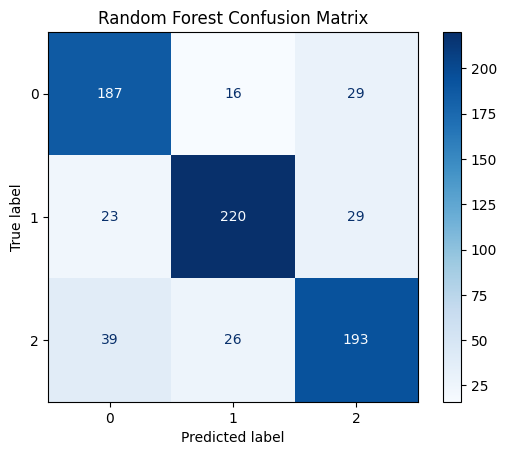

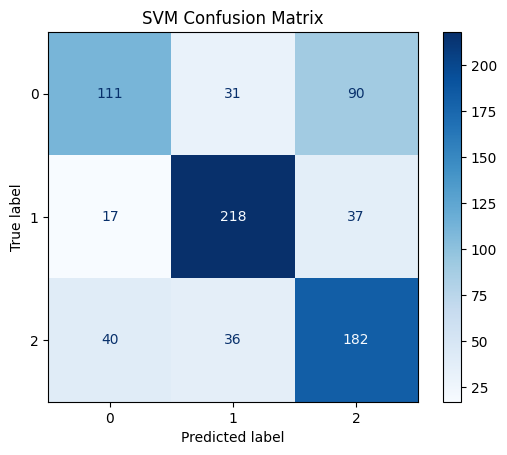

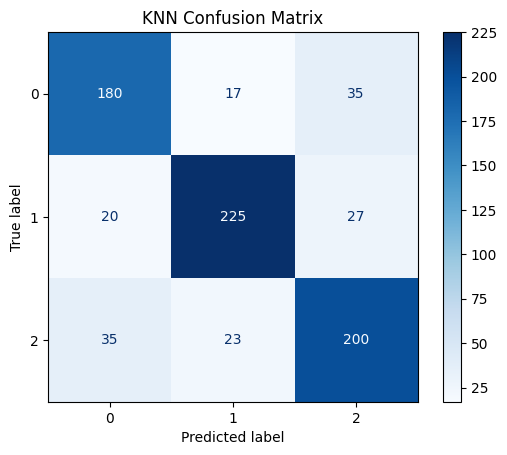

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")